# Import packages

In [1]:
# Install packages if not available

import importlib
import subprocess

required_packages = ['numpy', 'pandas', 'matplotlib', 
                     'pymrio', 'openpyxl', 'os', 
                     'scipy', 'networkx', 'pyreadr', 
                     'jaal', 'dash_html_components', 
                     'dash', 'sklearn.preprocessing', 'requests', 
                     'pyodbc', 'basemap', 'random']

for package in required_packages:
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        subprocess.check_call(['pip', 'install', package])



numpy is already installed.
pandas is already installed.
matplotlib is already installed.
pymrio is already installed.
openpyxl is already installed.
os is already installed.
scipy is already installed.
networkx is already installed.
pyreadr is already installed.


C:\Users\timur\anaconda3\lib\site-packages\dash_bootstrap_components\_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


jaal is already installed.
dash_html_components is already installed.
dash is already installed.
sklearn.preprocessing is already installed.
requests is already installed.
pyodbc is already installed.
basemap is not installed. Installing...
random is already installed.


In [2]:
# Import packages

import pandas as pd
import numpy as np
import pymrio
import openpyxl
import os
from scipy import linalg as lg
import networkx as nx
import pyreadr 
import matplotlib.pyplot as plt
import jaal
import dash_html_components as html
from dash import html
from jaal import Jaal
from jaal.datasets import load_got
from sklearn.preprocessing import MinMaxScaler
import requests
import pyodbc
from io import StringIO
from mpl_toolkits.basemap import Basemap
from random import choice

# Import file and clean data

In [3]:
# Create list of countries oecd and non-oecd

country_oecd = pd.read_excel(io = "http://stats.oecd.org/wbos/fileview2.aspx?IDFile=927334dd-d497-4f58-bc5f-40b7cc9b0468",
                            sheet_name = 'Country_Industry',
                            header = None,
                            names = ['alpha-3', 'country'],
                            usecols = "B:C",
                            skiprows = 3,
                            nrows = 44-4)
country_oecd["country_group"] = "oecd"

print(country_oecd.head())

country_nonoecd = pd.read_excel(io = "http://stats.oecd.org/wbos/fileview2.aspx?IDFile=927334dd-d497-4f58-bc5f-40b7cc9b0468",
                            sheet_name = 'Country_Industry',
                            header = None,
                            names = ['alpha-3', 'country'],
                            usecols = "D:E",
                            skiprows = 3,
                            nrows = 35-4)

country_nonoecd["country_group"] = "non-oecd"

print(country_nonoecd.head())


countries = pd.concat([country_oecd, country_nonoecd])

# Remove '.1 from country names'
countries["country"] = countries["country"].str.strip('.1')
countries["country"] = countries["country"].str.strip('.2')



  alpha-3    country country_group
0     AUS  Australia          oecd
1     AUT    Austria          oecd
2     BEL    Belgium          oecd
3     CAN     Canada          oecd
4     CHL      Chile          oecd
  alpha-3            country country_group
0     ARG          Argentina      non-oecd
1     BRA             Brazil      non-oecd
2     BRN  Brunei Darussalam      non-oecd
3     BGR           Bulgaria      non-oecd
4     KHM           Cambodia      non-oecd


In [4]:
# Import pre-calculated matrix MV on country level for 1995-2018

MVc = pd.read_csv('https://raw.githubusercontent.com/timurcode/OECD_Viz/main/MVc.csv', 
                  on_bad_lines='skip', sep=',', decimal = '.',
                  header = 0,
                  index_col = (0,1))

print(MVc.describe())


         Argentina    Australia      Austria      Belgium       Brazil  \
count  1656.000000  1656.000000  1656.000000  1656.000000  1656.000000   
mean      0.615811     0.614684     0.613226     0.599187     0.593543   
std       4.635945     4.403198     3.918223     3.468397     4.411815   
min       0.000016     0.000231     0.000103     0.000293     0.000030   
25%       0.002663     0.003392     0.010222     0.012960     0.002752   
50%       0.013395     0.024957     0.035203     0.047796     0.017721   
75%       0.044134     0.092179     0.147734     0.141356     0.064866   
max      41.888978    37.339914    34.947968    31.215480    38.932449   

       Brunei Darussalam     Bulgaria     Cambodia       Canada        Chile  \
count        1656.000000  1656.000000  1656.000000  1656.000000  1656.000000   
mean            0.643071     0.608089     0.605715     0.629799     0.608323   
std             4.215799     3.610640     3.575729     4.200161     4.198761   
min          

# Create edges and nodes dataframes for visualization

In [5]:
# Node

node_df = pd.DataFrame({'id':countries["country"], 
                      'alpha-3':countries["alpha-3"],
                       'country_group':countries["country_group"]})
print(node_df)

                   id alpha-3 country_group
0           Australia     AUS          oecd
1             Austria     AUT          oecd
2             Belgium     BEL          oecd
3              Canada     CAN          oecd
4               Chile     CHL          oecd
..                ...     ...           ...
26     Chinese Taipei     TWN      non-oecd
27           Thailand     THA      non-oecd
28            Tunisia     TUN      non-oecd
29           Viet Nam     VNM      non-oecd
30  Rest of the World     ROW      non-oecd

[71 rows x 3 columns]


In [6]:
# Dictionary of Geografical coordinates for countries

country_data = {
    'Australia': {'latitude': -25.2744, 'longitude': 133.7751},
    'Austria': {'latitude': 47.5162, 'longitude': 14.5501},
    'Belgium': {'latitude': 50.8503, 'longitude': 4.3517},
    'Canada': {'latitude': 56.1304, 'longitude': -106.3468},
    'Chile': {'latitude': -35.6751, 'longitude': -71.5430},
    'Colombia': {'latitude': 4.5709, 'longitude': -74.2973},
    'Costa Rica': {'latitude': 9.7489, 'longitude': -83.7534},
    'Czech Republic - Czechia': {'latitude': 49.8175, 'longitude': 15.4724},
    'Denmark': {'latitude': 56.2639, 'longitude': 9.5018},
    'Estonia': {'latitude': 58.5953, 'longitude': 25.0136},
    'Finland': {'latitude': 61.9241, 'longitude': 25.7482},
    'France': {'latitude': 46.6034, 'longitude': 1.8883},
    'Germany': {'latitude': 51.1657, 'longitude': 10.4515},
    'Greece': {'latitude': 39.0742, 'longitude': 21.8243},
    'Hungary': {'latitude': 47.1625, 'longitude': 19.5033},
    'Iceland': {'latitude': 64.9631, 'longitude': -19.0208},
    'Ireland': {'latitude': 53.3498, 'longitude': -6.2603},
    'Israel': {'latitude': 31.0461, 'longitude': 34.8516},
    'Italy': {'latitude': 41.8719, 'longitude': 12.5674},
    'Japan': {'latitude': 36.2048, 'longitude': 138.2529},
    'Korea': {'latitude': 35.9078, 'longitude': 127.7669},
    'Latvia': {'latitude': 56.8796, 'longitude': 24.6032},
    'Lithuania': {'latitude': 55.1694, 'longitude': 23.8813},
    'Luxembourg': {'latitude': 49.8153, 'longitude': 6.1296},
    'Mexico': {'latitude': 23.6345, 'longitude': -102.5528},
    'Mexico - Activities excluding Global Manufacturing': {'latitude': 23.6345, 'longitude': -102.5528},
    'Mexico - Global Manufacturing activities': {'latitude': 23.6345, 'longitude': -102.5528},
    'Netherlands': {'latitude': 52.1326, 'longitude': 5.2913},
    'New Zealand': {'latitude': -40.9006, 'longitude': 174.8860},
    'Norway': {'latitude': 60.4720, 'longitude': 8.4689},
    'Poland': {'latitude': 51.9194, 'longitude': 19.1451},
    'Portugal': {'latitude': 39.3999, 'longitude': -8.2245},
    'Slovak Republic': {'latitude': 48.6690, 'longitude': 19.6990},
    'Slovenia': {'latitude': 46.1512, 'longitude': 14.9955},
    'Spain': {'latitude': 40.4637, 'longitude': -3.7492},
    'Sweden': {'latitude': 60.1282, 'longitude': 18.6435},
    'Switzerland': {'latitude': 46.8182, 'longitude': 8.2275},
    'Turkey': {'latitude': 38.9637, 'longitude': 35.2433},
    'United Kingdom': {'latitude': 55.3781, 'longitude': -3.4360},
    'United States': {'latitude': 37.0902, 'longitude': -95.7129},
    'Argentina': {'latitude': -38.4161, 'longitude': -63.6167},
    'Brazil': {'latitude': -14.2350, 'longitude': -51.9253},
    'Brunei Darussalam': {'latitude': 4.5353, 'longitude': 114.7277},
    'Bulgaria': {'latitude': 42.7339, 'longitude': 25.4858},
    'Cambodia': {'latitude': 12.5657, 'longitude': 104.9910},
    'China (People\'s Republic of)': {'latitude': 35.8617, 'longitude': 104.1954},
    'China - Activities excluding export processing': {'latitude': 35.8617, 'longitude': 104.1954},
    'China - Export processing activities': {'latitude': 35.8617, 'longitude': 104.1954},
    'Croatia': {'latitude': 45.1000, 'longitude': 15.2000},
    'Cyprus': {'latitude': 35.1264, 'longitude': 33.4299},
    'India': {'latitude': 20.5937, 'longitude': 78.9629},
    'Indonesia': {'latitude': -0.7893, 'longitude': 113.9213},
    'Hong Kong, China': {'latitude': 22.3964, 'longitude': 114.1095},
    'Kazakhstan': {'latitude': 48.0196, 'longitude': 66.9237},
    'Lao People\'s Democratic Republic': {'latitude': 19.8563, 'longitude': 102.4955},
    'Malaysia': {'latitude': 4.2105, 'longitude': 101.9758},
    'Malta': {'latitude': 35.9375, 'longitude': 14.3754},
    'Morocco': {'latitude': 31.7917, 'longitude': -7.0926},
    'Myanmar': {'latitude': 21.9162, 'longitude': 95.9560},
    'Peru': {'latitude': -9.1900, 'longitude': -75.0152},
    'Philippines': {'latitude': 12.8797, 'longitude': 121.7740},
    'Romania': {'latitude': 45.9432, 'longitude': 24.9668},
    'Russian Federation': {'latitude': 61.5240, 'longitude': 105.3188},
    'Saudi Arabia': {'latitude': 23.8859, 'longitude': 45.0792},
    'Singapore': {'latitude': 1.3521, 'longitude': 103.8198},
    'South Africa': {'latitude': -30.5595, 'longitude': 22.9375},
    'Chinese Taipei': {'latitude': 23.6978, 'longitude': 120.9605},
    'Thailand': {'latitude': 15.8700, 'longitude': 100.9925},
    'Tunisia': {'latitude': 33.8869, 'longitude': 9.5375},
    'Viet Nam': {'latitude': 14.0583, 'longitude': 108.2772},
    'Rest of the World' : {'latitude': 6.535667, 'longitude': 20.231369}
}

# Add geografical coordinates to node_df

node_df['coordinates'] = node_df['id'].map(country_data)

In [7]:
# Edge all

# Convert Matrix into a long table (convert index columns as normal columns)
edge_df = pd.melt(MVc.reset_index(inplace = False), id_vars = ['year', 'country'], var_name = 'to', value_name = 'weight')

edge_df.rename(columns={'country':'from'}, inplace = True)

# Add a column which shows if the weight shows intracountry trade 
edge_df['intra'] = edge_df.apply(lambda row:True if row ['from'] == row['to'] else False, axis = 1)


edge_df['from'] = pd.Categorical(edge_df['from'])
edge_df['to'] = pd.Categorical(edge_df['to'])
edge_df.astype({'year':'int', 'from':'category', 'to':'category', 'weight':'float', 'intra':'bool'})

print(edge_df.dtypes)
print(edge_df.describe())


year         int64
from      category
to        category
weight     float64
intra         bool
dtype: object
                year         weight
count  114264.000000  114264.000000
mean     2006.500000       0.604323
std         6.922217       3.951262
min      1995.000000       0.000016
25%      2000.750000       0.007071
50%      2006.500000       0.030188
75%      2012.250000       0.112339
max      2018.000000      41.888978


# Filter the country of interest, the year and percentile of edges to be visualized 

Choose one of the countries: 
Australia, Austria, Belgium, Canada, Chile, Colombia, Costa Rica, Czech Republic - Czechia, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Iceland, Ireland, Israel, Italy, Japan, Korea, Latvia, Lithuania, Luxembourg, Mexico, Mexico - Activities excluding Global Manufacturing, Mexico - Global Manufacturing activities, Netherlands, New Zealand, Norway, Poland, Portugal, Slovak Republic, Slovenia, Spain, Sweden, Switzerland, Turkey, United Kingdom, United States, Argentina, Brazil, Brunei Darussalam, Bulgaria, Cambodia, China (People's Republic of), China - Activities excluding export processing, China - Export processing activities, Croatia, Cyprus, India, Indonesia, Hong Kong, China, Kazakhstan, Lao People's Democratic Republic, Malaysia, Malta, Morocco, Myanmar, Peru, Philippines, Romania, Russian Federation, Saudi Arabia, Singapore, South Africa, Chinese Taipei, Thailand, Tunisia, Viet Nam, Rest of the World. 

In [8]:
#Filter nodes for both visualizations


country_A = "Germany" # from the above list. 

year_select = 2018  #1995 - 2018

# Select percentile of edges to be depicted
weight_percentile = 7



In [9]:
# Create filtered dataframe based on filters

edge_df_filtered = edge_df.loc[((edge_df['to'] == country_A) | (edge_df['from'] == country_A)) & 
                               (edge_df['intra'] == 0) &
                               (edge_df['year'] == year_select) &
                                 (edge_df['weight'] > 
                                  np.percentile(edge_df.loc[(edge_df['year']==year_select) &
                                            ((edge_df['to'] == country_A) | (edge_df['from'] == country_A)) &
                                            (edge_df['intra'] == 0),'weight'], weight_percentile)), 
                               edge_df.columns != 'intra']

# Exclude revenue within a country

edge_df_filtered = edge_df_filtered.drop(edge_df_filtered.loc[edge_df_filtered['from'] == edge_df_filtered['to']].index)

# Add a marker for direction of a flow

edge_df_filtered['direction'] = edge_df_filtered.apply(lambda row:'from' if row ['from'] == country_A else 'to', axis = 1)

# Normalize weight for range between 1 and 10 (for more accurate network visualization)
edge_df_filtered['weight_norm'] = MinMaxScaler(feature_range=(1, 10)).fit_transform(edge_df_filtered[['weight']])



# Country-level network visualization


## Interactive visualization using Jaal based on the above filters

In [18]:
node_df[['id', 'alpha-3', 'country_group']]

,id,alpha-3,country_group
0,Australia,AUS,oecd
1,Austria,AUT,oecd
2,Belgium,BEL,oecd
3,Canada,CAN,oecd
4,Chile,CHL,oecd
...,...,...,...
26,Chinese Taipei,TWN,non-oecd
27,Thailand,THA,non-oecd
28,Tunisia,TUN,non-oecd
29,Viet Nam,VNM,non-oecd


In [21]:
viz = Jaal(edge_df_filtered, node_df[['id', 'alpha-3', 'country_group']]).plot(vis_opts={'physics':{'stabilization':{'iterations': 100}}}, # define the convergence iteration of network
                                     directed = True)





Parsing the data...Done


C:\Users\timur\anaconda3\lib\site-packages\jaal\datasets\parse_dataframe.py:57: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No trigger
inside color node country_group
inside color edge direction


[2023-09-10 22:00:38,604] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\timur\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\timur\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\timur\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\timur\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\timur\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\timur\anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "C:\Users\timur\anaconda3\lib\site-packages\dash\dash.py", l

Modifying edge size using  year
Modifying edge size using  weight_norm


## Country level static visualization using Networkx
Same filters are used

In [26]:
if 'G' in locals() and isinstance(G, nx.Graph):
    del G
G = nx.Graph()

for index, row in node_df.iterrows():  
    G.add_node(row['id'], alpha_3=row['alpha-3'], 
               country_group=row['country_group'], 
               pos=row['coordinates'],
              latitude = row['coordinates']['latitude'],
              longitude = row['coordinates']['longitude'])


for index, row in edge_df_filtered.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['weight'], weight_norm = row['weight_norm'])
    
G.remove_nodes_from([node for node, degree in dict(G.degree()).items() if degree == 0]) #Remove nodes with no edges

print("number of nodes: ", G.number_of_nodes())
print("number of edges: ", G.number_of_edges())


number of nodes:  69
number of edges:  68


{'Austria': Text(0.8170453396171016, 0.5714262842857879, 'AUT'),
 'France': Text(-0.6948263748254653, -0.3407762897407411, 'FRA'),
 'Germany': Text(0.0014389124367486285, -0.002501091561428761, 'DEU'),
 'Greece': Text(0.20684121992280466, -0.5203459504801135, 'GRC'),
 'Hungary': Text(-0.20377534197060845, -0.061540167870989995, 'HUN'),
 'Iceland': Text(0.5508254325659362, 0.0009092887342791744, 'ISL'),
 'Ireland': Text(-0.33122505845414996, -0.3011278087183511, 'IRL'),
 'Israel': Text(-0.6060820244018659, -0.6301677200967432, 'ISR'),
 'Italy': Text(-0.2455038354480465, 0.4190385499321973, 'ITA'),
 'Korea': Text(-0.6534853633884958, 0.6202978381232256, 'KOR'),
 'Latvia': Text(-0.4305846091957356, 0.32514239489204505, 'LVA'),
 'Lithuania': Text(-0.47505919301009153, -0.1444697213162136, 'LTU'),
 'Luxembourg': Text(-0.12995075492899572, 0.1229463151507293, 'LUX'),
 'Mexico - Global Manufacturing activities': Text(0.9185082730285405, -0.2692825331800876, 'MX2'),
 'Netherlands': Text(-0.144

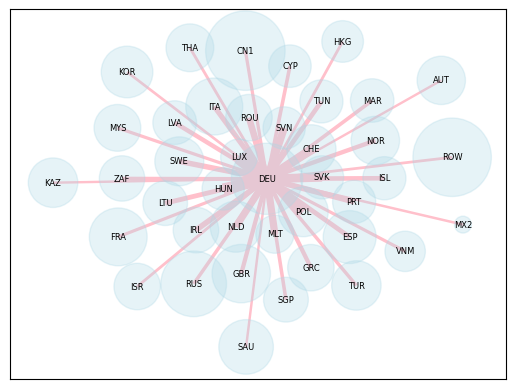

In [27]:
# If you wish to recreate, please re-run the previous step
# Keep only top x% of edges by weight
percentile = 6
edge_weights = nx.get_edge_attributes(G, 'weight_norm')
edge_weights_sorted = sorted(edge_weights.items(), key=lambda x: x[1], reverse=True)
num_edges_to_keep = int(len(edge_weights_sorted) * (percentile/10))
edges_to_keep = [edge[0] for edge in edge_weights_sorted[:num_edges_to_keep]]
G = G.edge_subgraph(edges_to_keep)

# Remove direction arrows and change edge width to reflect weight
pos = nx.spring_layout(G, k=3/np.sqrt(len(G.nodes())), iterations=500)
node_weights = {}
for country in G.nodes():
    node_weights[country] = MVc.loc[(year_select, country)].sum()
nx.draw_networkx_nodes(G, pos, alpha=0.3, node_color='lightblue', node_size=[30* node_weights[country] for country in G.nodes()])
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='pink', arrows=False, width=[G[u][v]['weight_norm'] for u, v in G.edges()])
nx.draw_networkx_labels(G, pos, {node: attr['alpha_3'] for node, attr in G.nodes(data=True)},
                        font_size=6, font_family='sans-serif')

# Display the plot

#plt.figure(figsize=(5, 5))
#plt.gca().set_facecolor('white')
#plt.axis('off')
#plt.savefig('MVc_1.png', dpi=400, format='png', bbox_inches = 'tight')
#plt.show()

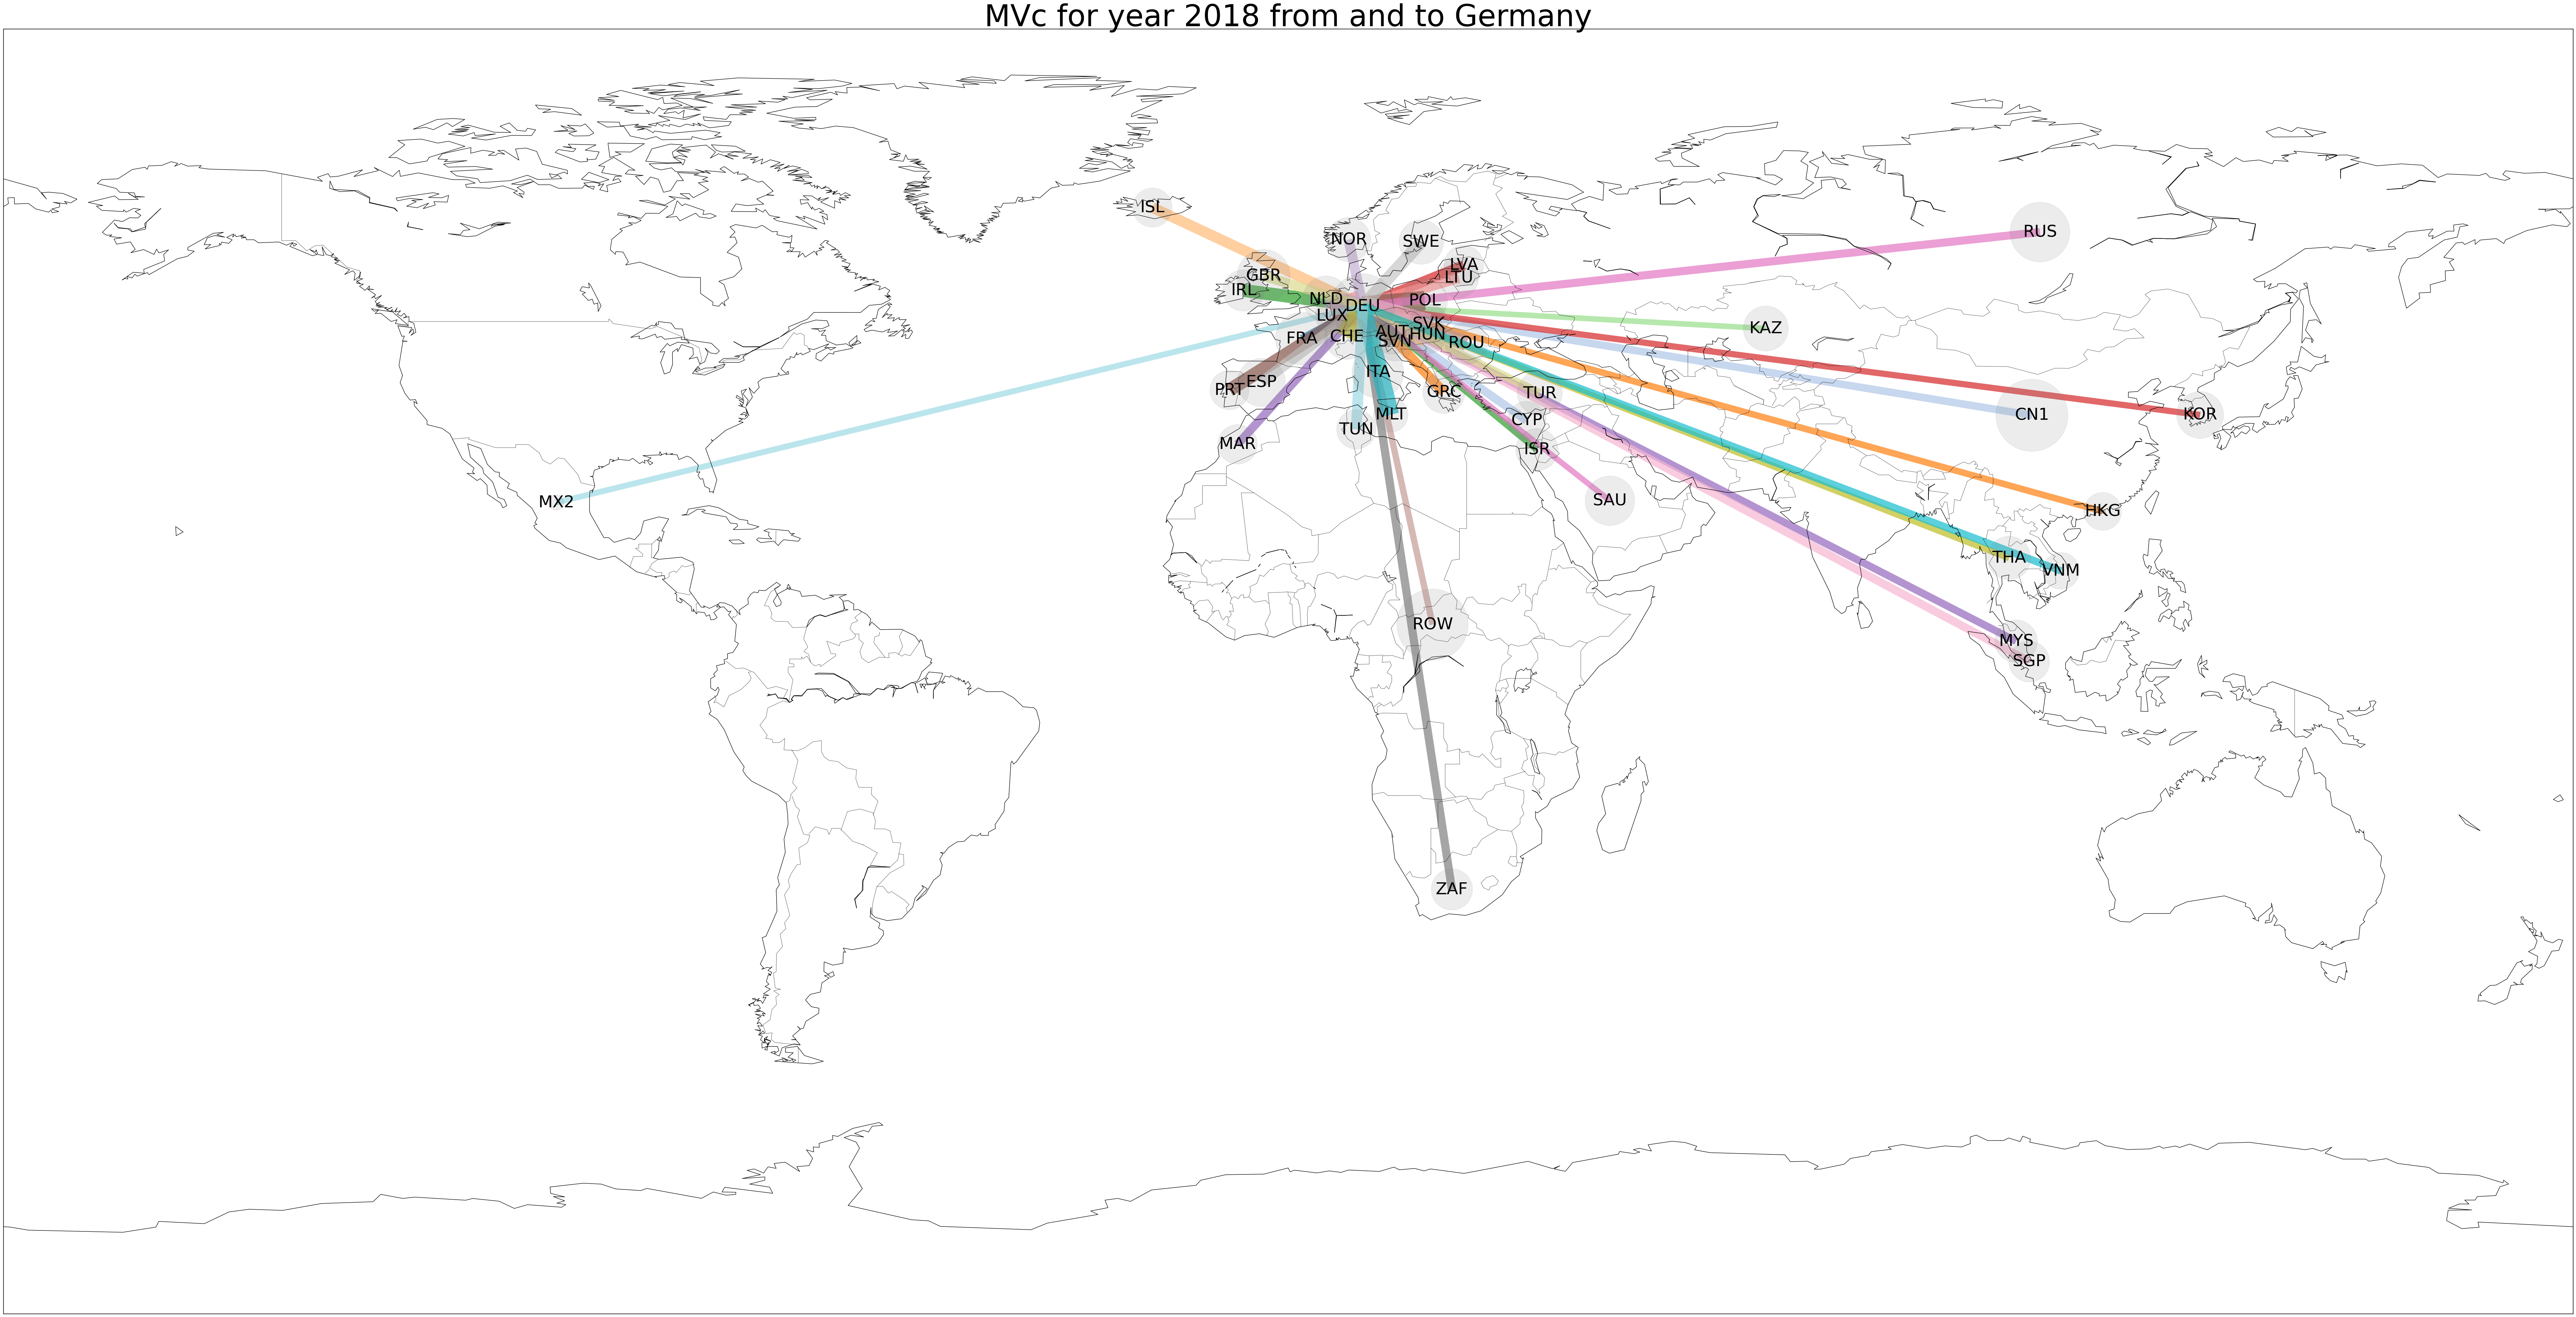

In [29]:
# Create a Basemap instance for the world map background
m = Basemap(projection='cyl', resolution='c', lon_0=0)

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(100, 85))

# Draw the world map background
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='white')


# Extract positions from the nodes using G.nodes(data=True)
node_positions = {node: (data['pos']['longitude'], data['pos']['latitude'])
                  for node, data in G.nodes(data=True)}
pos=node_positions
# Draw nodes with positions on top of the world map
#nx.draw(G, pos=node_positions, with_labels=True, node_size=100, ax=ax)
node_weights = {}
for country in G.nodes():
    node_weights[country] = MVc.loc[(year_select, country)].sum()*5
    
unique_colors = plt.cm.get_cmap('tab20', len(G.edges))

edge_colors = {edge: unique_colors(i) for i, edge in enumerate(G.edges())}
# Add the 'edge_color' attribute to the edges
nx.set_edge_attributes(G, edge_colors, 'edge_color')


    
nx.draw_networkx_nodes(G, pos, alpha=0.15, node_color='grey', node_size=[45*node_weights[country] for country in G.nodes()])
nx.draw_networkx_edges(G, pos, alpha=0.70, 
                       edgelist=G.edges(), 
                       edge_color=[G[u][v]['edge_color'] for u, v in G.edges()],
                       width=[G[u][v]['weight_norm']*7 for u, v in G.edges()])
nx.draw_networkx_labels(G, pos, {node: attr['alpha_3'] for node, attr in G.nodes(data=True)},
                        font_size=36, font_family='sans-serif')

# Customize the plot as needed
plt.title(f"MVc for year {year_select} from and to {country_A}", fontsize=65)

# Display the plot
plt.show()